# Machine Learning with vaex.ml

If you want to try out this notebook with a live Python kernel, use mybinder:

<a class="reference external image-reference" href="https://mybinder.org/v2/gh/vaexio/vaex/latest?filepath=docs%2Fsource%2Ftutorial_ml.ipynb"><img alt="https://mybinder.org/badge_logo.svg" src="https://mybinder.org/badge_logo.svg" width="150px"></a>


The `vaex.ml` package brings some machine learning algorithms to `vaex`. If you installed the individual subpackages (`vaex-core`, `vaex-hdf5`, ...) instead of the `vaex` metapackage, you may need to install it by running `pip install vaex-ml`, or `conda install -c conda-forge vaex-ml`.

The API of `vaex.ml` stays close to that of [scikit-learn](https://scikit-learn.org/stable/), while providing better performance and the ability to efficiently perform operations on data that is larger than the available RAM. This page is an overview and a brief introduction to the capabilities offered by `vaex.ml`.

In [1]:
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml

import numpy as np
import pylab as plt

We will use the well known [Iris flower](https://en.wikipedia.org/wiki/Iris_flower_data_set) and Titanic passenger list datasets, two classical datasets for machine learning demonstrations.

In [2]:
df = vaex.datasets.iris()
df

#,sepal_length,sepal_width,petal_length,petal_width,class_
0,5.9,3.0,4.2,1.5,1
1,6.1,3.0,4.6,1.4,1
2,6.6,2.9,4.6,1.3,1
3,6.7,3.3,5.7,2.1,2
4,5.5,4.2,1.4,0.2,0
...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0
146,5.1,3.8,1.6,0.2,0
147,5.8,2.6,4.0,1.2,1
148,5.7,3.8,1.7,0.3,0


/home/jovan/vaex/packages/vaex-core/vaex/viz/mpl.py:205: UserWarning: `scatter` is deprecated and it will be removed in version 5.x. Please use `df.viz.scatter` instead.
  warnings.warn('`scatter` is deprecated and it will be removed in version 5.x. Please use `df.viz.scatter` instead.')


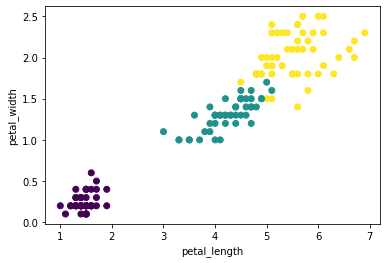

In [3]:
df.scatter(df.petal_length, df.petal_width, c_expr=df.class_);

## Preprocessing 

### Scaling of numerical features

`vaex.ml` packs the common numerical scalers:

* `vaex.ml.StandardScaler` - Scale features by removing their mean and dividing by their variance;
* `vaex.ml.MinMaxScaler` - Scale features to a given range;
* `vaex.ml.RobustScaler` - Scale features by removing their median and scaling them according to a given percentile range;
* `vaex.ml.MaxAbsScaler` - Scale features by their maximum absolute value.
 
The usage is quite similar to that of `scikit-learn`, in the sense that each transformer implements the `.fit` and `.transform` methods.

In [4]:
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
scaler = vaex.ml.StandardScaler(features=features, prefix='scaled_')
scaler.fit(df)
df_trans = scaler.transform(df)
df_trans

#,sepal_length,sepal_width,petal_length,petal_width,class_,scaled_petal_length,scaled_petal_width,scaled_sepal_length,scaled_sepal_width
0,5.9,3.0,4.2,1.5,1,0.25096730693923325,0.39617188299171285,0.06866179325140277,-0.12495760117130607
1,6.1,3.0,4.6,1.4,1,0.4784301228962429,0.26469891297233916,0.3109975341387059,-0.12495760117130607
2,6.6,2.9,4.6,1.3,1,0.4784301228962429,0.13322594295296575,0.9168368863569659,-0.3563605663033572
3,6.7,3.3,5.7,2.1,2,1.1039528667780207,1.1850097031079545,1.0380047568006185,0.5692512942248463
4,5.5,4.2,1.4,0.2,0,-1.341272404759837,-1.3129767272601438,-0.4160096885232057,2.6518779804133055
...,...,...,...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,-1.341272404759837,-1.3129767272601438,-0.7795132998541615,0.8006542593568975
146,5.1,3.8,1.6,0.2,0,-1.2275409967813318,-1.3129767272601438,-0.9006811702978141,1.726266119885101
147,5.8,2.6,4.0,1.2,1,0.13723589896072813,0.0017529729335920385,-0.052506077192249874,-1.0505694616995096
148,5.7,3.8,1.7,0.3,0,-1.1706752927920796,-1.18150375724077,-0.17367394763590144,1.726266119885101


The output of the `.transform` method of any `vaex.ml` transformer is a _shallow copy_ of a DataFrame that contains the resulting features of the transformations in addition to the original columns. A shallow copy means that this new DataFrame just references the original one, and no extra memory is used. In addition, the resulting features, in this case the scaled numerical features are _virtual columns,_ which do not take any memory but are computed on the fly when needed. This approach is ideal for working with very large datasets.

### Encoding of categorical features

`vaex.ml` contains several categorical encoders:

* `vaex.ml.LabelEncoder` - Encoding features with as many integers as categories, startinfg from 0;
* `vaex.ml.OneHotEncoder` - Encoding features according to the one-hot scheme;
* `vaex.ml.MultiHotEncoder` - Encoding features according to the multi-hot scheme (binary vector);
* `vaex.ml.FrequencyEncoder` - Encode features by the frequency of their respective categories;
* `vaex.ml.BayesianTargetEncoder` - Encode categories with the mean of their target value;
* `vaex.ml.WeightOfEvidenceEncoder` - Encode categories their weight of evidence value.
 
 The following is a quick example using the Titanic dataset.

In [5]:
df =  vaex.datasets.titanic()
df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO"
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON"
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON"
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,--,135,"Montreal, PQ / Chesterville, ON"
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON"


In [6]:
label_encoder = vaex.ml.LabelEncoder(features=['embarked'])
one_hot_encoder = vaex.ml.OneHotEncoder(features=['embarked'])
multi_hot_encoder = vaex.ml.MultiHotEncoder(features=['embarked'])
freq_encoder = vaex.ml.FrequencyEncoder(features=['embarked'])
bayes_encoder = vaex.ml.BayesianTargetEncoder(features=['embarked'], target='survived')
woe_encoder = vaex.ml.WeightOfEvidenceEncoder(features=['embarked'], target='survived')

df = label_encoder.fit_transform(df)
df = one_hot_encoder.fit_transform(df)
df = multi_hot_encoder.fit_transform(df)
df = freq_encoder.fit_transform(df)
df = bayes_encoder.fit_transform(df)
df = woe_encoder.fit_transform(df)

df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,label_encoded_embarked,embarked_missing,embarked_C,embarked_Q,embarked_S,embarked_0,embarked_1,embarked_2,frequency_encoded_embarked,mean_encoded_embarked,woe_encoded_embarked
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO",1,0,0,0,1,1,0,0,0.698243,0.337472,-0.696431
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0,0.698243,0.337472,-0.696431
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0,0.698243,0.337472,-0.696431
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,--,135,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0,0.698243,0.337472,-0.696431
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,1,0,0,0.698243,0.337472,-0.696431


Notice that the transformed features are all included in the resulting DataFrame and are appropriately named. This is excellent for the construction of various diagnostic plots, and engineering of more complex features. The fact that the resulting (encoded) features take no memory, allows one to try out or combine a variety of preprocessing steps without spending any extra memory. 

## Feature Engineering

### KBinsDiscretizer

With the `KBinsDiscretizer` you can convert a continous into a discrete feature by binning the data into specified intervals. You can specify the number of bins, the strategy on how to determine their size:

* "uniform" - all bins have equal sizes;
* "quantile" - all bins have (approximately) the same number of samples in them;
* "kmeans" - values in each bin belong to the same 1D cluster as determined by the `KMeans` algorithm.

In [7]:
kbdisc = vaex.ml.KBinsDiscretizer(features=['age'], n_bins=5, strategy='quantile')
df = kbdisc.fit_transform(df)
df.head(5)

/home/jovan/vaex/packages/vaex-core/vaex/ml/transformations.py:1089: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in   age are removed.Consider decreasing the number of bins.
  warnings.warn(f'Bins whose width are too small (i.e., <= 1e-8) in   {feat} are removed.'


#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,label_encoded_embarked,embarked_missing,embarked_C,embarked_Q,embarked_S,frequency_encoded_embarked,mean_encoded_embarked,woe_encoded_embarked,binned_age
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO",1,0,0,0,1,0.698243,0.337472,-0.696431,0
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,--,135,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0


### GroupBy Transformer

The `GroupByTransformer` is a handy feature in `vaex-ml` that lets you perform a groupby aggregations on the training data, and then use those aggregations as features in the training and test sets.

In [8]:
gbt = vaex.ml.GroupByTransformer(by='pclass', agg={'age': ['mean', 'std'],
                                                   'fare': ['mean', 'std'],
                                                  })
df = gbt.fit_transform(df)
df.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,label_encoded_embarked,embarked_missing,embarked_C,embarked_Q,embarked_S,frequency_encoded_embarked,mean_encoded_embarked,woe_encoded_embarked,binned_age,age_mean,age_std,fare_mean,fare_std
0,1,True,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.338,B5,S,2,nan,"St Louis, MO",1,0,0,0,1,0.698243,0.337472,-0.696431,0,39.1599,14.5224,87.509,80.3226
1,1,True,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0,39.1599,14.5224,87.509,80.3226
2,1,False,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0,39.1599,14.5224,87.509,80.3226
3,1,False,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,--,135,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0,39.1599,14.5224,87.509,80.3226
4,1,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,--,nan,"Montreal, PQ / Chesterville, ON",1,0,0,0,1,0.698243,0.337472,-0.696431,0,39.1599,14.5224,87.509,80.3226


### CycleTransformer

The `CycleTransformer` provides a strategy for transforming cyclical features, such as angles or time. This is done by considering each feature to be describing a polar coordinate system, and converting it to Cartesian coorindate system. 
This is shown to help certain ML models to achieve better performance.

In [9]:
df = vaex.from_arrays(days=[0, 1, 2, 3, 4, 5, 6])
cyctrans = vaex.ml.CycleTransformer(n=7, features=['days'])
cyctrans.fit_transform(df)

#,days,days_x,days_y
0,0,1,0
1,1,0.62349,0.781831
2,2,-0.222521,0.974928
3,3,-0.900969,0.433884
4,4,-0.900969,-0.433884
5,5,-0.222521,-0.974928
6,6,0.62349,-0.781831


## Dimensionality reduction 

### Principal Component Analysis

The [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) implemented in `vaex.ml` can scale to a very large number of samples, even if that data we want to transform does not fit into RAM. To demonstrate this, let us do a PCA transformation on the Iris dataset. For this example, we have replicated this dataset thousands of times, such that it contains over **1 billion** samples.

In [10]:
df = vaex.datasets.iris_1e9()
n_samples = len(df)
print(f'Number of samples in DataFrame: {n_samples:,}')

Number of samples in DataFrame: 1,005,000,000


In [11]:
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
pca = vaex.ml.PCA(features=features, n_components=4)
pca.fit(df, progress='widget')

The PCA transformer implemented in `vaex.ml` can be fit in well under a minute, even when the data comprises 4 columns and 1 billion rows. 

In [12]:
df_trans = pca.transform(df)
df_trans

#,sepal_length,sepal_width,petal_length,petal_width,class_,PCA_0,PCA_1,PCA_2,PCA_3
0,5.9,3.0,4.2,1.5,1,-0.5110980605065719,0.10228410590320294,0.13232789125239366,-0.05010053260756789
1,6.1,3.0,4.6,1.4,1,-0.8901604456484571,0.03381244269907491,-0.009768028904991795,0.1534482059864868
2,6.6,2.9,4.6,1.3,1,-1.0432977809309918,-0.2289569106597803,-0.41481456509035997,0.03752354509774891
3,6.7,3.3,5.7,2.1,2,-2.275853649246034,-0.3333865237191275,0.28467815436304544,0.062230281630705805
4,5.5,4.2,1.4,0.2,0,2.5971594768136956,-1.1000219282272325,0.16358191524058419,0.09895807321522321
...,...,...,...,...,...,...,...,...,...
"1,004,999,995",5.2,3.4,1.4,0.2,0,2.6398212682948925,-0.3192900674870881,-0.1392533720548284,-0.06514104909063131
"1,004,999,996",5.1,3.8,1.6,0.2,0,2.537573370908207,-0.5103675457748862,0.17191840236558648,0.19216594960009262
"1,004,999,997",5.8,2.6,4.0,1.2,1,-0.2288790498772652,0.4022576190683287,-0.22736270650701024,-0.01862045442675292
"1,004,999,998",5.7,3.8,1.7,0.3,0,2.199077961161723,-0.8792440894091085,-0.11452146077196179,-0.025326942106218664


Recall that the transformed DataFrame, which includes the PCA components, takes no extra memory. 

### Incremental PCA

The PCA implementation in vaex is very fast, but more so for "tall" DataFrames, i.e. DataFrames that have many rows, but not many columns. For DataFrames that have hundreds of columns,  it is more efficient to use an Incremental PCA method. `vaex.ml` provides a convenient method that essentialy wraps `sklearn.decomposition.IncrementalPCA`, the fitting of which is more efficient for "wide" DataFrames. 

The usage is practically identical to the regular PCA method. Consider the following example:

In [13]:
n_samples = 100_000
n_columns = 50
data_dict = {f'feat_{i}': np.random.normal(0, i+1, size=n_samples) for i in range(n_columns)}
df = vaex.from_dict(data_dict)


features = df.get_column_names()
pca = vaex.ml.PCAIncremental(n_components=10, features=features, batch_size=42_000)
pca.fit(df, progress='widget')
pca.transform(df)

#,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9
0,0.21916619701436382,-1.1435438188965208,-2.236473242690611,-8.81728920352771,1.9931414225984159,0.8289809515418928,-7.847441537857684,-5.990636964340006,0.43889103534482576,-6.4855757436955965,-14.485326967682871,13.825392548457543,-5.5661773929038185,-3.1816868599382633,27.665651019727836,50.541940500115366,16.001390451665785,32.510983357481614,8.342038455860216,-1.7293759207235855,-6.451472523437187,22.55340570655327,-2.5431251220412645,28.75425936065127,-39.487762558467345,-6.871003398404642,11.198673922236354,-86.63832306461876,-7.323680791059892,37.35407351193795,23.653897939827836,39.52047029873747,42.79143756690254,-33.3810495394693,33.05317072490505,14.818285601642208,-67.03187283353228,-19.01476952180615,22.4905763733386,35.33833686808974,11.79457050704157,-86.70070654092856,25.185781359852896,20.521240128349977,19.814114866123216,78.05531698592385,10.029892443326418,-97.39820288821723,-0.9603735180566161,-64.45083314406774,-67.59977551168708,9.37969253153906,-96.6057651764448,11.206098841188833,74.90790318762694,17.531645576460654,21.26591694292548,27.215113714718253,-85.31326664717933,10.507088586039371
1,-0.4207695878149816,2.3850692704428043,-1.3661921493141755,-0.5746498072120483,2.2588675039630703,-5.100101894797036,-0.0005433423021984177,-3.0055202143012365,5.749693220009271,11.379708067727588,10.119772822286162,0.15698369211085733,-10.937595546203902,-31.110839874678003,-5.593388174686233,-17.488517420539235,19.942127063793418,-0.6804349583522779,-19.037083924637454,28.74230527011865,12.40206875918237,-9.990549218761593,-5.733244330514869,3.171827795840886,-43.944372783025386,-25.882058852476312,3.517534442545183,-25.104631728721504,17.068162563601867,-26.188188765123446,-17.51765346352225,-5.803234686368941,23.37461204071744,85.58386322836444,-24.84250900935848,42.2583557612343,-34.836257741275844,47.25447854289113,-5.903960946365425,47.891908734840925,-9.673715993876817,-17.577477482028527,4.066254744412671,-51.377913297883865,-11.519870067465668,10.497653831847085,16.358701536495925,-18.391482505602802,9.858101501060483,-39.819369217021595,-38.74298336407881,12.412960580526423,-16.791761088244527,14.714058887306741,8.607153125744537,-6.384705477156807,-52.877991595848066,3.667728062420572,-19.219755720289232,-16.20164176309122
2,-0.5024797409195991,0.9897062935454243,-1.152229281759237,-1.682033038083704,-4.091345910790923,-4.5274240377188555,2.129578282936375,10.936320913755608,-1.5695520680947808,-6.034199421988269,-28.46431144964817,-15.32129294377632,-8.194011820344523,-16.218630438043398,12.021916867709596,-4.908477966578501,-29.56619559878632,7.772108300044394,7.680046493196698,13.815505542053483,3.9208120473170016,47.34661694033482,1.544881077052938,9.440027347582042,18.56198304730558,22.3336072648248,-21.578332510459486,-48.930926635722656,16.5701671385727,16.656088505245513,19.8406469884787,5.384567961213235,-16.733924287448616,14.376438801233908,-35.323974854495155,-7.411178531711759,-12.191336793311075,57.91740496088699,34.873491696833774,88.28464395597479,87.65337555912684,-2.4096431528212445,-7.8171455961597385,-4.016403896979926,-22.96261029782406,-75.8940296403038,-38.8951677113029,-89.75675908427556,-79.5994302281645,-44.45310265105787,-42.34987503786076,-74.13417710288375,-94.54423466637282,-40.877591489278196,-73.38521818144409,-14.487330945685514,-6.8530939766408885,-10.84894017617582,-0.03886564832609524,78.63468911909872
3,0.12617606561304665,-0.9172822637869823,1.8277090696240983,-1.8883963021695365,-3.2608534381741343,6.94314682034098,-1.9

Note that you need `scikit-learn` installed to only fit the `PCAIncremental` transformer. The the `transform` method does not rely on `scikit-learn` being installed.


### Random projections

Random projections is another popular way of doing dimensionality reduction, especially when the dimensionality of the data is very high. `vaex.ml` conveniently wraps both `scikit-learn.random_projection.GaussianRandomProjection` and `scikit-learn.random_projection.SparseRandomProjection` in a single `vaex.ml` transformer. 

In [14]:
rand_proj = vaex.ml.RandomProjections(features=features, n_components=10)
rand_proj.fit(df)
rand_proj.transform(df)

#,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,feat_13,feat_14,feat_15,feat_16,feat_17,feat_18,feat_19,feat_20,feat_21,feat_22,feat_23,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,feat_33,feat_34,feat_35,feat_36,feat_37,feat_38,feat_39,feat_40,feat_41,feat_42,feat_43,feat_44,feat_45,feat_46,feat_47,feat_48,feat_49,random_projection_0,random_projection_1,random_projection_2,random_projection_3,random_projection_4,random_projection_5,random_projection_6,random_projection_7,random_projection_8,random_projection_9
0,0.21916619701436382,-1.1435438188965208,-2.236473242690611,-8.81728920352771,1.9931414225984159,0.8289809515418928,-7.847441537857684,-5.990636964340006,0.43889103534482576,-6.4855757436955965,-14.485326967682871,13.825392548457543,-5.5661773929038185,-3.1816868599382633,27.665651019727836,50.541940500115366,16.001390451665785,32.510983357481614,8.342038455860216,-1.7293759207235855,-6.451472523437187,22.55340570655327,-2.5431251220412645,28.75425936065127,-39.487762558467345,-6.871003398404642,11.198673922236354,-86.63832306461876,-7.323680791059892,37.35407351193795,23.653897939827836,39.52047029873747,42.79143756690254,-33.3810495394693,33.05317072490505,14.818285601642208,-67.03187283353228,-19.01476952180615,22.4905763733386,35.33833686808974,11.79457050704157,-86.70070654092856,25.185781359852896,20.521240128349977,19.814114866123216,78.05531698592385,10.029892443326418,-97.39820288821723,-0.9603735180566161,-64.45083314406774,-50.62485790513975,-8.969974902164104,-75.59787959901278,-32.23015488522056,-8.839635748773595,25.52280920491688,-67.81125847807398,20.625813141370337,-8.9492512335752,-38.397093148408445
1,-0.4207695878149816,2.3850692704428043,-1.3661921493141755,-0.5746498072120483,2.2588675039630703,-5.100101894797036,-0.0005433423021984177,-3.0055202143012365,5.749693220009271,11.379708067727588,10.119772822286162,0.15698369211085733,-10.937595546203902,-31.110839874678003,-5.593388174686233,-17.488517420539235,19.942127063793418,-0.6804349583522779,-19.037083924637454,28.74230527011865,12.40206875918237,-9.990549218761593,-5.733244330514869,3.171827795840886,-43.944372783025386,-25.882058852476312,3.517534442545183,-25.104631728721504,17.068162563601867,-26.188188765123446,-17.51765346352225,-5.803234686368941,23.37461204071744,85.58386322836444,-24.84250900935848,42.2583557612343,-34.836257741275844,47.25447854289113,-5.903960946365425,47.891908734840925,-9.673715993876817,-17.577477482028527,4.066254744412671,-51.377913297883865,-11.519870067465668,10.497653831847085,16.358701536495925,-18.391482505602802,9.858101501060483,-39.819369217021595,-24.167592671736728,-83.6194525409906,-31.474566122257382,-53.51874280599636,-9.295953556730474,12.065310248051029,21.935134361477004,-72.0479982398111,-66.96195351258001,76.22398276816658
2,-0.5024797409195991,0.9897062935454243,-1.152229281759237,-1.682033038083704,-4.091345910790923,-4.5274240377188555,2.129578282936375,10.936320913755608,-1.5695520680947808,-6.034199421988269,-28.46431144964817,-15.32129294377632,-8.194011820344523,-16.218630438043398,12.021916867709596,-4.908477966578501,-29.56619559878632,7.772108300044394,7.680046493196698,13.815505542053483,3.9208120473170016,47.34661694033482,1.544881077052938,9.440027347582042,18.56198304730558,22.3336072648248,-21.578332510459486,-48.930926635722656,16.5701671385727,16.656088505245513,19.8406469884787,5.384567961213235,-16.733924287448616,14.376438801233908,-35.323974854495155,-7.411178531711759,-12.191336793311075,57.91740496088699,34.873491696833774,88.28464395597479,87.65337555912684,-2.4096431528212445,-7.8171455961597385,-4.016403896979926,-22.96261029782406,-75.8940296403038,-38.8951677113029,-89.75675908427556,-79.5994302281645,-44.45310265105787,-30.370561351797924,-69.21024877654797,-131.21336032017504,-23.81397986098913,90.48694640695885,27.981469036784446,-71.13131857248655,-165.47320481693575,30.36401943353085,-37

## Clustering

### K-Means

`vaex.ml` implements a fast and scalable K-Means clustering algorithm. The usage is similar to that of `scikit-learn`.

In [15]:
import vaex.ml.cluster

df = vaex.datasets.iris()

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
kmeans = vaex.ml.cluster.KMeans(features=features, n_clusters=3, max_iter=100, verbose=True, random_state=42)
kmeans.fit(df)

df_trans = kmeans.transform(df)
df_trans

Iteration    0, inertia  519.0500000000001
Iteration    1, inertia  156.70447116074328
Iteration    2, inertia  88.70688235734133
Iteration    3, inertia  80.23054939305554
Iteration    4, inertia  79.28654263977778
Iteration    5, inertia  78.94084142614601
Iteration    6, inertia  78.94084142614601


#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction_kmeans
0,5.9,3.0,4.2,1.5,1,0
1,6.1,3.0,4.6,1.4,1,0
2,6.6,2.9,4.6,1.3,1,0
3,6.7,3.3,5.7,2.1,2,1
4,5.5,4.2,1.4,0.2,0,2
...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,2
146,5.1,3.8,1.6,0.2,0,2
147,5.8,2.6,4.0,1.2,1,0
148,5.7,3.8,1.7,0.3,0,2


K-Means is an unsupervised algorithm, meaning that the predicted cluster labels in the transformed dataset do not necessarily correspond to the class label. We can map the predicted cluster identifiers to match the class labels, making it easier to construct diagnostic plots.

In [16]:
df_trans['predicted_kmean_map'] = df_trans.prediction_kmeans.map(mapper={0: 1, 1: 2, 2: 0})
df_trans

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction_kmeans,predicted_kmean_map
0,5.9,3.0,4.2,1.5,1,0,1
1,6.1,3.0,4.6,1.4,1,0,1
2,6.6,2.9,4.6,1.3,1,0,1
3,6.7,3.3,5.7,2.1,2,1,2
4,5.5,4.2,1.4,0.2,0,2,0
...,...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,2,0
146,5.1,3.8,1.6,0.2,0,2,0
147,5.8,2.6,4.0,1.2,1,0,1
148,5.7,3.8,1.7,0.3,0,2,0


Now we can construct simple scatter plots, and see that in the case of the Iris dataset, K-Means does a pretty good job splitting the data into 3 classes.

/home/jovan/vaex/packages/vaex-core/vaex/viz/mpl.py:205: UserWarning: `scatter` is deprecated and it will be removed in version 5.x. Please use `df.viz.scatter` instead.
  warnings.warn('`scatter` is deprecated and it will be removed in version 5.x. Please use `df.viz.scatter` instead.')


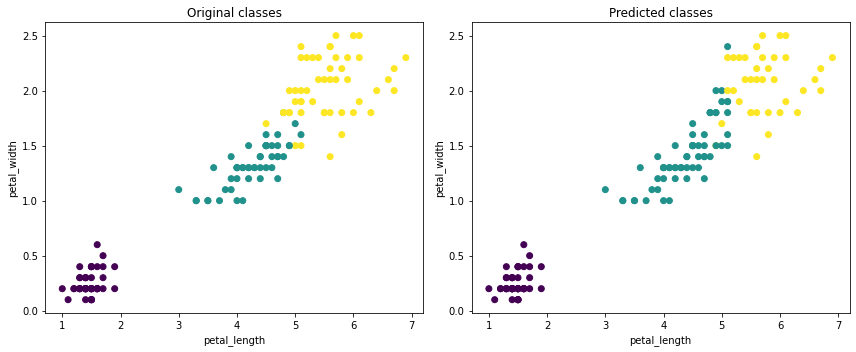

In [17]:
fig = plt.figure(figsize=(12, 5))

plt.subplot(121)
df_trans.scatter(df_trans.petal_length, df_trans.petal_width, c_expr=df_trans.class_)
plt.title('Original classes')

plt.subplot(122)
df_trans.scatter(df_trans.petal_length, df_trans.petal_width, c_expr=df_trans.predicted_kmean_map)
plt.title('Predicted classes')

plt.tight_layout()
plt.show()

As with any algorithm implemented in `vaex.ml`, K-Means can be used on billions of samples. Fitting takes **under 2 minutes** when applied on the oversampled Iris dataset, numbering over **1 billion** samples.

In [18]:
df = vaex.datasets.iris_1e9()
n_samples = len(df)
print(f'Number of samples in DataFrame: {n_samples:,}')

Number of samples in DataFrame: 1,005,000,000


In [19]:
%%time

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
kmeans = vaex.ml.cluster.KMeans(features=features, n_clusters=3, max_iter=100, verbose=True, random_state=31)
kmeans.fit(df)

Iteration    0, inertia  838974000.0037192
Iteration    1, inertia  535903134.000306
Iteration    2, inertia  530190921.4848897
Iteration    3, inertia  528931941.03372437
Iteration    4, inertia  528931941.0337243
CPU times: user 2min 37s, sys: 1.26 s, total: 2min 39s
Wall time: 19.9 s


## Supervised learning

While `vaex.ml` does not yet implement any supervised machine learning models, it does provide wrappers to several popular libraries such as [scikit-learn](https://scikit-learn.org/), [XGBoost](https://xgboost.readthedocs.io/), [LightGBM](https://lightgbm.readthedocs.io/) and [CatBoost](https://catboost.ai/). 

The main benefit of these wrappers is that they turn the models into `vaex.ml` transformers. This means the models become part of the DataFrame _state_ and thus can be serialized, and their predictions can be returned as _virtual columns_. This is especially useful for creating various diagnostic plots and evaluating performance metrics at no memory cost, as well as building ensembles. 

### `Scikit-Learn` example

The `vaex.ml.sklearn` module provides convenient wrappers to the `scikit-learn` estimators. In fact, these wrappers can be used with any library that follows the API convention established by `scikit-learn`, i.e. implements the `.fit` and `.transform` methods.

Here is an example:

In [20]:
from vaex.ml.sklearn import Predictor
from sklearn.ensemble import GradientBoostingClassifier

df = vaex.datasets.iris()

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

model = GradientBoostingClassifier(random_state=42)
vaex_model = Predictor(features=features, target=target, model=model, prediction_name='prediction')

vaex_model.fit(df=df)

df = vaex_model.transform(df)
df

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction
0,5.9,3.0,4.2,1.5,1,1
1,6.1,3.0,4.6,1.4,1,1
2,6.6,2.9,4.6,1.3,1,1
3,6.7,3.3,5.7,2.1,2,2
4,5.5,4.2,1.4,0.2,0,0
...,...,...,...,...,...,...
145,5.2,3.4,1.4,0.2,0,0
146,5.1,3.8,1.6,0.2,0,0
147,5.8,2.6,4.0,1.2,1,1
148,5.7,3.8,1.7,0.3,0,0


One can still train a predictive model on datasets that are too big to fit into memory by leveraging the on-line learners provided by `scikit-learn`. The `vaex.ml.sklearn.IncrementalPredictor` conveniently wraps these learners and provides control on how the data is passed to them from a `vaex` DataFrame. 

Let us train a model on the oversampled Iris dataset which comprises over 1 billion samples.

In [21]:
from vaex.ml.sklearn import IncrementalPredictor
from sklearn.linear_model import SGDClassifier

df = vaex.datasets.iris_1e9()

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

model = SGDClassifier(learning_rate='constant', eta0=0.0001, random_state=42)
vaex_model = IncrementalPredictor(features=features, target=target, model=model, 
                                  batch_size=500_000, partial_fit_kwargs={'classes':[0, 1, 2]})

vaex_model.fit(df=df, progress='widget')

df = vaex_model.transform(df)
df

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction
0,5.9,3.0,4.2,1.5,1,1
1,6.1,3.0,4.6,1.4,1,1
2,6.6,2.9,4.6,1.3,1,1
3,6.7,3.3,5.7,2.1,2,2
4,5.5,4.2,1.4,0.2,0,0
...,...,...,...,...,...,...
"1,004,999,995",5.2,3.4,1.4,0.2,0,0
"1,004,999,996",5.1,3.8,1.6,0.2,0,0
"1,004,999,997",5.8,2.6,4.0,1.2,1,1
"1,004,999,998",5.7,3.8,1.7,0.3,0,0


### `XGBoost` example

Libraries such as `XGBoost` provide more options such as validation during training and early stopping for example. We provide wrappers that keeps close to the native API of these libraries, in addition to the `scikit-learn` API. 

While the following example showcases the `XGBoost` wrapper, `vaex.ml` implements similar wrappers for `LightGBM` and `CatBoost`.

In [22]:
from vaex.ml.xgboost import XGBoostModel

df = vaex.datasets.iris_1e5()
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

params = {'learning_rate': 0.1,
          'max_depth': 3, 
          'num_class': 3, 
          'objective': 'multi:softmax',
          'subsample': 1,
          'random_state': 42,
          'n_jobs': -1}


booster = XGBoostModel(features=features, target=target, num_boost_round=500, params=params)
booster.fit(df=df_train, evals=[(df_train, 'train'), (df_test, 'test')], early_stopping_rounds=5)

df_test = booster.transform(df_train)
df_test

[13:41:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#,sepal_length,sepal_width,petal_length,petal_width,class_,xgboost_prediction
0,5.9,3.0,4.2,1.5,1,1.0
1,6.1,3.0,4.6,1.4,1,1.0
2,6.6,2.9,4.6,1.3,1,1.0
3,6.7,3.3,5.7,2.1,2,2.0
4,5.5,4.2,1.4,0.2,0,0.0
...,...,...,...,...,...,...
"80,395",5.2,3.4,1.4,0.2,0,0.0
"80,396",5.1,3.8,1.6,0.2,0,0.0
"80,397",5.8,2.6,4.0,1.2,1,1.0
"80,398",5.7,3.8,1.7,0.3,0,0.0


### `CatBoost` example

The CatBoost library supports summing up models. With this feature, we can use CatBoost to train a model using data that is otherwise too large to fit in memory. The idea is to train a single CatBoost model per chunk of data, and than sum up the invidiual models to create a master model. To use this feature via `vaex.ml` just specify the `batch_size` argument in the `CatBoostModel` wrapper. One can also specify additional options such as the strategy on how to sum up the individual models, or how they should be weighted.

In [23]:
from vaex.ml.catboost import CatBoostModel

df = vaex.datasets.iris_1e8()
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

params = {
    'leaf_estimation_method': 'Gradient',
    'learning_rate': 0.1,
    'max_depth': 3,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'sampling_frequency': 'PerTree',
    'colsample_bylevel': 0.8,
    'reg_lambda': 1,
    'objective': 'MultiClass',
    'eval_metric': 'MultiClass',
    'random_state': 42,
    'verbose': 0,
}

booster = CatBoostModel(features=features, target=target, num_boost_round=23, 
                        params=params, prediction_type='Class', batch_size=11_000_000)
booster.fit(df=df_train, progress='widget')

df_test = booster.transform(df_train)
df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,catboost_prediction
0,5.9,3.0,4.2,1.5,1,array([1])
1,6.1,3.0,4.6,1.4,1,array([1])
2,6.6,2.9,4.6,1.3,1,array([1])
3,6.7,3.3,5.7,2.1,2,array([2])
4,5.5,4.2,1.4,0.2,0,array([0])
...,...,...,...,...,...,...
"80,399,995",5.2,3.4,1.4,0.2,0,array([0])
"80,399,996",5.1,3.8,1.6,0.2,0,array([0])
"80,399,997",5.8,2.6,4.0,1.2,1,array([1])
"80,399,998",5.7,3.8,1.7,0.3,0,array([0])


### `Keras` example

`Keras` is the most popular high-level API to building neural network models with tensorflow as its backend. Neural networks can have very diverse and complicated architectures, and their training loops can be both simple and sophisticated. This is why, at least for now, we leave the users to train their `keras` models as they normaly would, and in `vaex-ml` provides a simple wrapper for serialization and lazy evaluation of those models. In addition, `vaex-ml` also provides a convenience method to turn a DataFrame into a generator, suitable for training of `Keras` models. See the example below.

In [24]:
import vaex.ml.tensorflow
import tensorflow.keras as K

df = vaex.example()
df_train, df_valid, df_test = df.split_random([0.8, 0.1, 0.1], random_state=42)

features = ['x', 'y', 'z', 'vx', 'vy', 'vz']
target = 'FeH'

# Scaling the features
df_train = df_train.ml.minmax_scaler(features=features)
features = df_train.get_column_names(regex='^minmax_')

# Apply preprocessing to the validation
state_prep = df_train.state_get()
df_valid.state_set(state_prep)

# Generators for the train and validation sets
gen_train = df_train.ml.tensorflow.to_keras_generator(features=features, target=target, batch_size=512)
gen_valid = df_valid.ml.tensorflow.to_keras_generator(features=features, target=target, batch_size=512)

# Create and fit a simple Sequential Keras model
nn_model = K.Sequential()
nn_model.add(K.layers.Dense(3, activation='tanh'))
nn_model.add(K.layers.Dense(1, activation='linear'))
nn_model.compile(optimizer='sgd', loss='mse')
nn_model.fit(x=gen_train, validation_data=gen_valid, epochs=11, steps_per_epoch=516, validation_steps=65)

# Serialize the model
keras_model = vaex.ml.tensorflow.KerasModel(features=features, prediction_name='keras_pred', model=nn_model)
df_train = keras_model.transform(df_train)

# Apply all the transformations to the test set
state = df_train.state_get()
df_test.state_set(state)

# Preview the results
df_test.head(5)

2021-08-14 23:47:55.800260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-14 23:47:55.800282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Recommended "steps_per_epoch" arg: 516.0
Recommended "steps_per_epoch" arg: 65.0


2021-08-14 23:47:57.111408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-14 23:47:57.111910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-14 23:47:57.111974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-08-14 23:47:57.112032: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-08-14 23:47:57.112093: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/11
 11/516 [..............................] - ETA: 2s - loss: 1.7922  

2021-08-14 23:47:57.326751: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


516/516 [==============================] - 3s 6ms/step - loss: 0.2172 - val_loss: 0.1724
Epoch 2/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1736 - val_loss: 0.1715
Epoch 3/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1729 - val_loss: 0.1705
Epoch 4/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1725 - val_loss: 0.1707
Epoch 5/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1722 - val_loss: 0.1708
Epoch 6/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1720 - val_loss: 0.1701
Epoch 7/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1718 - val_loss: 0.1697
Epoch 8/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1717 - val_loss: 0.1706
Epoch 9/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1715 - val_loss: 0.1698
Epoch 10/11
516/516 [==============================] - 3s 6ms/step - loss: 0.1714 - val_loss: 0.1702
Epoch 11/1

2021-08-14 23:48:31.519641: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


#,id,x,y,z,vx,vy,vz,E,L,Lz,FeH,minmax_scaled_x,minmax_scaled_y,minmax_scaled_z,minmax_scaled_vx,minmax_scaled_vy,minmax_scaled_vz,keras_pred
0,23,0.137403,-5.07974,1.40165,111.828,62.8776,-88.121,-134786,700.236,576.698,-1.7935,0.375163,0.72055,0.397008,0.570648,0.56065,0.414253,"array([-1.6143968], dtype=float32)"
1,31,-1.95543,-0.840676,1.26239,-259.282,20.8279,-148.457,-134990,676.813,-258.7,-0.623007,0.365132,0.738746,0.395427,0.266912,0.5249,0.357964,"array([-1.509573], dtype=float32)"
2,22,2.33077,-0.570014,0.761285,-53.4566,-43.377,-71.3196,-177062,196.209,-131.573,-0.889463,0.385676,0.739908,0.389737,0.43537,0.470313,0.429927,"array([-1.5752358], dtype=float32)"
3,26,0.777881,-2.83258,0.0797214,256.427,202.451,-12.76,-125176,884.581,883.833,-1.65996,0.378233,0.730196,0.381998,0.688994,0.679314,0.484558,"array([-1.6558373], dtype=float32)"
4,1,3.37429,2.62885,-0.797169,300.697,153.772,83.9173,-97150.4,681.868,-271.616,-1.6496,0.390678,0.753639,0.372041,0.725228,0.637928,0.574749,"array([-1.6719546], dtype=float32)"


### `River` example

`River` is an up-and-coming library for online learning, and provides a variety of models that can learn incrementally. While most of the `river` models currently support per-sample training, few do support mini-batch training which is extremely fast - a great synergy to do machine learning with vaex.

In [25]:
from vaex.ml.incubator.river import RiverModel
from river.linear_model import LinearRegression
from river import optim


df = vaex.datasets.iris_1e9()
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

river_model = RiverModel(features=features,
                         target=target,
                         model=LinearRegression(optimizer=optim.SGD(0.001), intercept_lr=0.001),
                         prediction_name='prediction_raw',
                         batch_size=500_000)
river_model.fit(df_train, progress='widget')
river_model.transform(df_test)

#,sepal_length,sepal_width,petal_length,petal_width,class_,prediction_raw
0,5.9,3.0,4.2,1.5,1,1.2262451850482554
1,6.1,3.0,4.6,1.4,1,1.3372106202149072
2,6.6,2.9,4.6,1.3,1,1.3080263625894342
3,6.7,3.3,5.7,2.1,2,1.8246442870772779
4,5.5,4.2,1.4,0.2,0,-0.1719159051653813
...,...,...,...,...,...,...
"200,999,995",5.2,3.4,1.4,0.2,0,-0.06961837848289065
"200,999,996",5.1,3.8,1.6,0.2,0,-0.04133966888449841
"200,999,997",5.8,2.6,4.0,1.2,1,1.1380612859534056
"200,999,998",5.7,3.8,1.7,0.3,0,-0.005633275295105093


## Metrics

`vaex-ml` also provides several of the most common evaluation metrics for classification and regression tasks. These metrics are implemented in `vaex-ml` and thus are evaluated out-of-core, so you do not need to materialize the target and predicted columns. 

Here is a list of the currently supported metrics:

- Classification (binary, and macro-average for multiclass problems):
    - Accuracy
    - Precision
    - Recall
    - F1-score
    - Confusion matrix
    - Classification report (a convenience method, which prints out the accuracy, precision, recall, and F1-score at the same time)
    - Matthews Correlation Coeficient
- Regression
    - Mean Absolute Error
    - Mean Squared Error
    - R<sup>2</sup> Correlation Score

Here is a simple example:

In [26]:
import vaex.ml.metrics
from sklearn.linear_model import LogisticRegression

df = vaex.datasets.iris()
df_train, df_test = df.split_random([0.8, 0.2], random_state=55)

features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']
target = 'class_'

model = LogisticRegression(random_state=42)
vaex_model = Predictor(features=features, target=target, model=model, prediction_name='pred')

vaex_model.fit(df=df_train)

df_test = vaex_model.transform(df_test)

print(df_test.ml.metrics.classification_report(df_test.class_, df_test.pred, average='macro'))


        Classification report:

        Accuracy:  0.933
        Precision: 0.928
        Recall:    0.928
        F1:        0.928
        


/home/jovan/vaex/packages/vaex-core/vaex/dataframe.py:5516: UserWarning: It seems your column class_ is already ordinal encoded (values between 0 and 2), automatically switching to use df.categorize
  warnings.warn(f'It seems your column {column} is already ordinal encoded (values between {min_value} and {max_value}), automatically switching to use df.categorize')
/home/jovan/vaex/packages/vaex-core/vaex/dataframe.py:5516: UserWarning: It seems your column pred is already ordinal encoded (values between 0 and 2), automatically switching to use df.categorize
  warnings.warn(f'It seems your column {column} is already ordinal encoded (values between {min_value} and {max_value}), automatically switching to use df.categorize')


## State transfer - pipelines made easy

Each `vaex` DataFrame consists of two parts: _data_ and _state_. The _data_ is immutable, and any operation such as filtering, adding new columns, or applying transformers or predictive models just modifies the _state_. This is extremely powerful concept and can completely redefine how we imagine machine learning pipelines. 

As an example, let us once again create a model based on the Iris dataset. Here, we will create a couple of new features, do a PCA transformation, and finally train a predictive model. 

In [27]:
# Load data and split it in train and test sets
df = vaex.datasets.iris()
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

# Create new features
df_train['petal_ratio'] = df_train.petal_length / df_train.petal_width
df_train['sepal_ratio'] = df_train.sepal_length / df_train.sepal_width

# Do a PCA transformation
features = ['petal_length', 'petal_width', 'sepal_length', 'sepal_width', 'petal_ratio', 'sepal_ratio']
pca = vaex.ml.PCA(features=features, n_components=6)
df_train = pca.fit_transform(df_train)

# Display the training DataFrame at this stage
df_train

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5
0,5.4,3.0,4.5,1.5,1,3.0,1.8,-1.510547480171215,0.3611524321126822,-0.4005106138591812,0.5491844107628985,0.21135370342329635,-0.009542243224854377
1,4.8,3.4,1.6,0.2,0,8.0,1.411764705882353,4.447550641536847,0.2799644730487585,-0.04904458661276928,0.18719360579644695,0.10928493945448532,0.005228919010020094
2,6.9,3.1,4.9,1.5,1,3.266666666666667,2.2258064516129035,-1.777649528149752,-0.6082889770845891,0.48007833550651513,-0.37762011866831335,0.05174472701894024,-0.04673816474220924
3,4.4,3.2,1.3,0.2,0,6.5,1.375,3.400548263702555,1.437036928591846,-0.3662652846960042,0.23420836198441913,0.05750021481634099,-0.023055011653267066
4,5.6,2.8,4.9,2.0,2,2.45,2.0,-2.3245098766222094,0.14710673877401348,-0.5150809942258257,0.5471824391426298,-0.12154714382375817,0.0044686197532133876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,5.2,3.4,1.4,0.2,0,6.999999999999999,1.5294117647058825,3.623794583238953,0.8255759252729563,0.23453320686724874,-0.17599408825208826,-0.04687036865354327,-0.02424621891240747
116,5.1,3.8,1.6,0.2,0,8.0,1.3421052631578947,4.42115266246093,0.22287505533663704,0.4450642830179705,0.2184424557783562,0.14504752606375293,0.07229123907677276
117,5.8,2.6,4.0,1.2,1,3.3333333333333335,2.230769230769231,-1.069062832993727,0.3874258314654399,-0.4471767749236783,-0.2956609879568117,-0.0010695982441835394,-0.0065225306610744715
118,5.7,3.8,1.7,0.3,0,5.666666666666667,1.5000000000000002,2.2846521048417037,1.1920826609681359,0.8273738848637026,-0.21048946462725737,0.03381892388998425,0.018792165273013528


At this point, we are ready to train a predictive model. In this example, let's use `LightGBM` with its `scikit-learn` API. 

In [28]:
import lightgbm

features = df_train.get_column_names(regex='^PCA')

booster = lightgbm.LGBMClassifier()

vaex_model = Predictor(model=booster, features=features, target='class_')

vaex_model.fit(df=df_train)
df_train = vaex_model.transform(df_train)

df_train

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,prediction
0,5.4,3.0,4.5,1.5,1,3.0,1.8,-1.510547480171215,0.3611524321126822,-0.4005106138591812,0.5491844107628985,0.21135370342329635,-0.009542243224854377,1
1,4.8,3.4,1.6,0.2,0,8.0,1.411764705882353,4.447550641536847,0.2799644730487585,-0.04904458661276928,0.18719360579644695,0.10928493945448532,0.005228919010020094,0
2,6.9,3.1,4.9,1.5,1,3.266666666666667,2.2258064516129035,-1.777649528149752,-0.6082889770845891,0.48007833550651513,-0.37762011866831335,0.05174472701894024,-0.04673816474220924,1
3,4.4,3.2,1.3,0.2,0,6.5,1.375,3.400548263702555,1.437036928591846,-0.3662652846960042,0.23420836198441913,0.05750021481634099,-0.023055011653267066,0
4,5.6,2.8,4.9,2.0,2,2.45,2.0,-2.3245098766222094,0.14710673877401348,-0.5150809942258257,0.5471824391426298,-0.12154714382375817,0.0044686197532133876,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,5.2,3.4,1.4,0.2,0,6.999999999999999,1.5294117647058825,3.623794583238953,0.8255759252729563,0.23453320686724874,-0.17599408825208826,-0.04687036865354327,-0.02424621891240747,0
116,5.1,3.8,1.6,0.2,0,8.0,1.3421052631578947,4.42115266246093,0.22287505533663704,0.4450642830179705,0.2184424557783562,0.14504752606375293,0.07229123907677276,0
117,5.8,2.6,4.0,1.2,1,3.3333333333333335,2.230769230769231,-1.069062832993727,0.3874258314654399,-0.4471767749236783,-0.2956609879568117,-0.0010695982441835394,-0.0065225306610744715,1
118,5.7,3.8,1.7,0.3,0,5.666666666666667,1.5000000000000002,2.2846521048417037,1.1920826609681359,0.8273738848637026,-0.21048946462725737,0.03381892388998425,0.018792165273013528,0


The final `df_train` DataFrame contains all the features we created, including the predictions right at the end. Now, we would like to apply the same transformations to the test set. All we need to do, is to simply extract the _state_ from `df_train` and apply it to `df_test`. This will propagate all the changes that were made to the training set on the test set.


In [29]:
state = df_train.state_get()

df_test.state_set(state)
df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,prediction
0,5.9,3.0,4.2,1.5,1,2.8000000000000003,1.9666666666666668,-1.642627940409072,0.49931302910747727,-0.06308800806664466,0.10842057110641677,-0.03924298664189224,-0.027394439700272822,1
1,6.1,3.0,4.6,1.4,1,3.2857142857142856,2.033333333333333,-1.445047446393471,-0.1019091578746504,-0.01899012239493801,0.020980767646090408,0.1614215276667148,-0.02716639637934938,1
2,6.6,2.9,4.6,1.3,1,3.538461538461538,2.2758620689655173,-1.330564613235537,-0.41978474749131267,0.1759590589290671,-0.4631301992308477,0.08304243689815374,-0.033351733677429274,1
3,6.7,3.3,5.7,2.1,2,2.7142857142857144,2.0303030303030303,-2.6719170661531013,-0.9149428897499291,0.4156162725009377,0.34633692661436644,0.03742964707590906,-0.013254286196245774,2
4,5.5,4.2,1.4,0.2,0,6.999999999999999,1.3095238095238095,3.6322930267831404,0.8198526437905096,1.046277579362938,0.09738737839850209,0.09412658096734221,0.1329137026697501,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,5.5,2.5,4.0,1.3,1,3.0769230769230766,2.2,-1.2523120088600896,0.5975071562677784,-0.7019801415469216,-0.11489031841855571,-0.03615945782087869,0.005496321827264977,1
26,5.8,2.7,3.9,1.2,1,3.25,2.148148148148148,-1.0792352165904657,0.5236883751378523,-0.34037717939532286,-0.23743695029955128,-0.00936891422024664,-0.02184110533380834,1
27,4.4,2.9,1.4,0.2,0,6.999999999999999,1.517241379310345,3.7422969192506095,1.048460304741977,-0.636475521315278,0.07623157913054074,0.004215355833312173,-0.06354157393133958,0
28,4.5,2.3,1.3,0.3,0,4.333333333333334,1.956521739130435,1.4537380535696471,2.4197864889383505,-1.0301500321688102,-0.5150263062576134,-0.2631218962099228,-0.06608059456656257,0


And just like that `df_test` contains all the columns, transformations and the prediction we modelled on the training set. The state can be easily serialized to disk in a form of a JSON file. This makes deployment of a machine learning model as trivial as simply copying a JSON file from one environment to another.

In [30]:
df_train.state_write('./iris_model.json')

df_test.state_load('./iris_model.json')
df_test

#,sepal_length,sepal_width,petal_length,petal_width,class_,petal_ratio,sepal_ratio,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,prediction
0,5.9,3.0,4.2,1.5,1,2.8000000000000003,1.9666666666666668,-1.642627940409072,0.49931302910747727,-0.06308800806664466,0.10842057110641677,-0.03924298664189224,-0.027394439700272822,1
1,6.1,3.0,4.6,1.4,1,3.2857142857142856,2.033333333333333,-1.445047446393471,-0.1019091578746504,-0.01899012239493801,0.020980767646090408,0.1614215276667148,-0.02716639637934938,1
2,6.6,2.9,4.6,1.3,1,3.538461538461538,2.2758620689655173,-1.330564613235537,-0.41978474749131267,0.1759590589290671,-0.4631301992308477,0.08304243689815374,-0.033351733677429274,1
3,6.7,3.3,5.7,2.1,2,2.7142857142857144,2.0303030303030303,-2.6719170661531013,-0.9149428897499291,0.4156162725009377,0.34633692661436644,0.03742964707590906,-0.013254286196245774,2
4,5.5,4.2,1.4,0.2,0,6.999999999999999,1.3095238095238095,3.6322930267831404,0.8198526437905096,1.046277579362938,0.09738737839850209,0.09412658096734221,0.1329137026697501,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,5.5,2.5,4.0,1.3,1,3.0769230769230766,2.2,-1.2523120088600896,0.5975071562677784,-0.7019801415469216,-0.11489031841855571,-0.03615945782087869,0.005496321827264977,1
26,5.8,2.7,3.9,1.2,1,3.25,2.148148148148148,-1.0792352165904657,0.5236883751378523,-0.34037717939532286,-0.23743695029955128,-0.00936891422024664,-0.02184110533380834,1
27,4.4,2.9,1.4,0.2,0,6.999999999999999,1.517241379310345,3.7422969192506095,1.048460304741977,-0.636475521315278,0.07623157913054074,0.004215355833312173,-0.06354157393133958,0
28,4.5,2.3,1.3,0.3,0,4.333333333333334,1.956521739130435,1.4537380535696471,2.4197864889383505,-1.0301500321688102,-0.5150263062576134,-0.2631218962099228,-0.06608059456656257,0
